<a href="https://colab.research.google.com/github/elangbijak4/Blockchain_Research/blob/main/Blockchain2_DAG_dan_PoP_(Proof_of_Participants).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kode di bawah masih belum sempurna karena algoritma validasi rantai masih mengikuti paradigma rantai hash linier, bukan graf DAG. Sehingga mungkin kadang menghasilkan validasi yang "False".

In [52]:
import json

In [53]:
import hashlib
import time

class Block:
    # Tambahkan atribut contract untuk menyimpan smart contract
    def __init__(self, index, previous_hashes, timestamp, data, hash, contract=None):
        self.index = index
        self.previous_hashes = previous_hashes
        self.timestamp = timestamp
        self.data = data
        self.hash = hash
        self.contract = contract

    @staticmethod
    def calculate_hash(index, previous_hashes, timestamp, data):
        value = str(index) + ''.join(previous_hashes) + str(timestamp) + data
        return hashlib.sha256(value.encode('utf-8')).hexdigest()

    @staticmethod
    def create_genesis_block():
        return Block(0, ["0"], time.time(), "Genesis Block", Block.calculate_hash(0, ["0"], time.time(), "Genesis Block"))

    def to_dict(self):
        return {
            'index': self.index,
            'previous_hashes': self.previous_hashes,
            'timestamp': self.timestamp,
            'data': self.data,
            'hash': self.hash,
            'contract': self.contract.contract_id if self.contract else None
        }

In [33]:
class BlockchainDAG_Old:
    def __init__(self):
        self.chain = [Block.create_genesis_block()]
        self.blocks = {self.chain[0].hash: self.chain[0]}  # Dictionary to store blocks by hash

    def get_latest_blocks(self, n=1):
        latest_blocks = sorted(self.chain, key=lambda x: x.timestamp, reverse=True)[:n]
        return latest_blocks

    def add_block(self, new_block):
        for previous_hash in new_block.previous_hashes:
            if previous_hash not in self.blocks:
                raise ValueError("One or more previous hashes not found in the chain")
        new_block.hash = Block.calculate_hash(new_block.index, new_block.previous_hashes, new_block.timestamp, new_block.data)
        self.chain.append(new_block)
        self.blocks[new_block.hash] = new_block

    def is_chain_valid(self):
        for block in self.chain:
            calculated_hash = Block.calculate_hash(block.index, block.previous_hashes, block.timestamp, block.data)
            if block.hash != calculated_hash:
                return False
            for previous_hash in block.previous_hashes:
                if previous_hash not in self.blocks:
                    return False
        return True

    def to_json(self):
        chain_data = [block.to_dict() for block in self.chain]
        return json.dumps(chain_data, indent=4)

In [59]:
class BlockchainDAG:
    def __init__(self):
        self.chain = [Block.create_genesis_block()]
        self.blocks = {self.chain[0].hash: self.chain[0]}  # Dictionary to store blocks by hash

    def get_latest_blocks(self, n=1):
        latest_blocks = sorted(self.chain, key=lambda x: x.timestamp, reverse=True)[:n]
        return latest_blocks

    def add_block(self, new_block):
        for previous_hash in new_block.previous_hashes:
            if previous_hash not in self.blocks:
                raise ValueError("One or more previous hashes not found in the chain")
        new_block.hash = Block.calculate_hash(new_block.index, new_block.previous_hashes, new_block.timestamp, new_block.data)
        self.chain.append(new_block)
        self.blocks[new_block.hash] = new_block

    def is_chain_valid(self):
        for block in self.chain:
            calculated_hash = Block.calculate_hash(block.index, block.previous_hashes, block.timestamp, block.data)
            if block.hash != calculated_hash:
                return False
            for previous_hash in block.previous_hashes:
                if previous_hash not in self.blocks:
                    return False

        return True

    def to_json(self):
        chain_data = [block.to_dict() for block in self.chain]
        return json.dumps(chain_data, indent=4)

In [60]:
class Validator:
    def __init__(self, name):
        self.name = name
        self.participation = 0

    def participate(self):
        self.participation += 1

class PoP:
    def __init__(self):
        self.validators = []

    def add_validator(self, validator):
        self.validators.append(validator)

    def select_validator(self):
        max_participation = max([v.participation for v in self.validators])
        for validator in self.validators:
            if validator.participation == max_participation:
                return validator

In [51]:
# Demo penggunaan
blockchain = BlockchainDAG()
pop = PoP()

validator1 = Validator("Validator1")
validator2 = Validator("Validator2")

pop.add_validator(validator1)
pop.add_validator(validator2)

# Simulating participation
validator1.participate()
validator2.participate()
validator2.participate()

selected_validator = pop.select_validator()
print(f"Selected Validator: {selected_validator.name}")

# Adding a new block by selected validator
previous_hashes = [blockchain.get_latest_blocks()[0].hash]
new_block = Block(len(blockchain.chain), previous_hashes, time.time(), "Some Data", "")
blockchain.add_block(new_block)

print("Blockchain is valid:", blockchain.is_chain_valid())

print("Blockchain JSON representation:")
print(blockchain.to_json())

Selected Validator: Validator2
Blockchain is valid: False
Blockchain JSON representation:
[
    {
        "index": 0,
        "previous_hashes": [
            "0"
        ],
        "timestamp": 1720708577.6394534,
        "data": "Genesis Block",
        "hash": "54f60c65533cee2fe71518601e30aec1c4f9d072e0338e7f408fd6985cef9886",
        "contract": null
    },
    {
        "index": 1,
        "previous_hashes": [
            "54f60c65533cee2fe71518601e30aec1c4f9d072e0338e7f408fd6985cef9886"
        ],
        "timestamp": 1720708577.6401916,
        "data": "Some Data",
        "hash": "dbd75f95fc58a06c0431c62a383773e084b62916b3114e84ff2901ca591d6ca2",
        "contract": null
    }
]


In [61]:
import networkx as nx
import matplotlib.pyplot as plt

class BlockchainVisualizer:
    def __init__(self, blockchain):
        self.blockchain = blockchain
        self.graph = nx.DiGraph()

    def build_graph(self):
        for block in self.blockchain.chain:
            self.graph.add_node(block.hash, label=f"Block {block.index}")
            for prev_hash in block.previous_hashes:
                self.graph.add_edge(prev_hash, block.hash)

    def draw_graph(self):
        pos = nx.spring_layout(self.graph)
        labels = nx.get_node_attributes(self.graph, 'label')
        nx.draw(self.graph, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
        plt.show()

In [62]:
class SmartContract:
    def __init__(self, contract_id, code):
        self.contract_id = contract_id
        self.code = code

    def execute(self, *args):
        exec(self.code, globals(), locals())
        return locals().get('result', None)

Selected Validator: Validator2
Blockchain is valid: False
Blockchain JSON representation:
[
    {
        "index": 0,
        "previous_hashes": [
            "0"
        ],
        "timestamp": 1720708797.5829616,
        "data": "Genesis Block",
        "hash": "fa758ae53771c1254a560370a11efd3bb612332ef9ab3bb1ad76d4441d58df6b",
        "contract": null
    },
    {
        "index": 1,
        "previous_hashes": [
            "fa758ae53771c1254a560370a11efd3bb612332ef9ab3bb1ad76d4441d58df6b"
        ],
        "timestamp": 1720708797.584818,
        "data": "Data Block 1",
        "hash": "2a9f08607dd0fdc2575a8997b44861ecb2f5c0854e9af7c25b2d0e0c8c406afc",
        "contract": null
    },
    {
        "index": 2,
        "previous_hashes": [
            "2a9f08607dd0fdc2575a8997b44861ecb2f5c0854e9af7c25b2d0e0c8c406afc"
        ],
        "timestamp": 1720708797.5851526,
        "data": "Data Block 2",
        "hash": "5cf355340461048525634205648de5e05cd7905b874cfbae9082bfc865d83c5e",
 

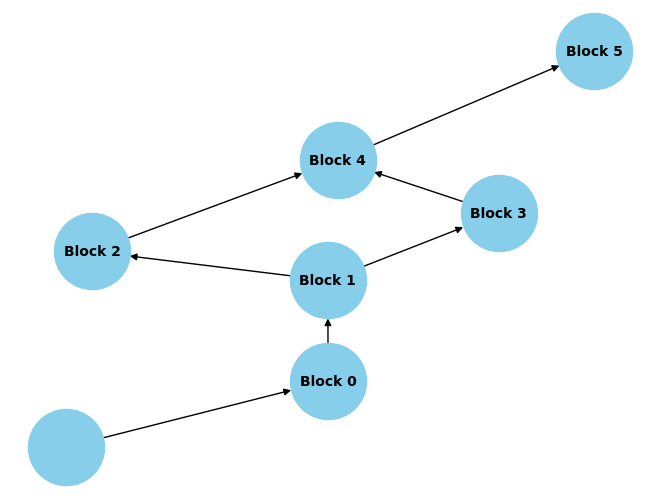

In [63]:
# Demo penggunaan dengan smart contract dan validasi yang diperbaiki
blockchain = BlockchainDAG()
pop = PoP()

validator1 = Validator("Validator1")
validator2 = Validator("Validator2")

pop.add_validator(validator1)
pop.add_validator(validator2)

# Simulating participation
validator1.participate()
validator2.participate()
validator2.participate()

selected_validator = pop.select_validator()
print(f"Selected Validator: {selected_validator.name}")

# Menambahkan beberapa blok untuk membentuk pencabangan
previous_hashes = [blockchain.get_latest_blocks()[0].hash]
new_block1 = Block(len(blockchain.chain), previous_hashes, time.time(), "Data Block 1", "")
blockchain.add_block(new_block1)

previous_hashes = [new_block1.hash]
new_block2 = Block(len(blockchain.chain), previous_hashes, time.time(), "Data Block 2", "")
blockchain.add_block(new_block2)

previous_hashes = [new_block1.hash]
new_block3 = Block(len(blockchain.chain), previous_hashes, time.time(), "Data Block 3", "")
blockchain.add_block(new_block3)

previous_hashes = [new_block2.hash, new_block3.hash]
new_block4 = Block(len(blockchain.chain), previous_hashes, time.time(), "Data Block 4", "")
blockchain.add_block(new_block4)

print("Blockchain is valid:", blockchain.is_chain_valid())

print("Blockchain JSON representation:")
print(blockchain.to_json())

# Membuat smart contract
contract_code = """
def contract_function(x, y):
    result = x + y
result = contract_function(5, 10)
"""
smart_contract = SmartContract("contract1", contract_code)

# Menambahkan smart contract ke dalam blok
previous_hashes = [new_block4.hash]
new_block_with_contract = Block(len(blockchain.chain), previous_hashes, time.time(), "Smart Contract Block", "", contract=smart_contract)
blockchain.add_block(new_block_with_contract)

print("Blockchain with Smart Contract JSON representation:")
print(blockchain.to_json())

# Pemanggilan dan eksekusi smart contract
result = new_block_with_contract.contract.execute()
print("Smart Contract Execution Result:", result)

# Visualisasi DAG
visualizer = BlockchainVisualizer(blockchain)
visualizer.build_graph()
visualizer.draw_graph()